# Amazon Musical Instruments Reviews 


In this project, I will perform EDA on the Amazon Musical Instruments Reviews dataset to gain insights into the data, identify potential issues, and prepare it for classification using NLP techniques. 

The dataset contains reviews for musical instruments sold on Amazon, along with their corresponding ratings. The goal is to classify the reviews as positive or negative based on their text content. Before building a classification model, I will need to perform EDA to understand the distribution of the data, identify missing values, outliers, and other anomalies, and preprocess the data to make it suitable for NLP tasks.

On this project I will be use python and some popular data science libaries such as pandas, numpy, matplotlib and seaborn to perform the EDA. I will compute basic statistics, generate visualizations, and analyze the distribution of the data.  

## Content
This file has reviewer ID , User ID, Reviewer Name, Reviewer text, helpful, Summary(obtained from Reviewer text),Overall Rating on a scale 5, Review time
Description of columns in the file:

* **reviewerID** - ID of the reviewer, e.g. A2SUAM1J3GNN3B
* **asin** - ID of the product, e.g. 0000013714
* **reviewerName** - name of the reviewer
* **helpful** - helpfulness rating of the review, e.g. 2/3
* **reviewText** - text of the review
* **overall** - rating of the product
* **summary** - summary of the review
* **unixReviewTime** - time of the review (unix time)
* **reviewTime** - time of the review (raw)


In [1]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Engineering
import nltk
import string
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from collections import Counter

# Model
from nltk.stem import WordNetLemmatizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, cross_val_score
import pickle

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Evaluation
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

sns.set_palette("muted")
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Joao\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Joao\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Data Cleaning

### Importing Data

In [2]:
raw_data = os.path.join('..','data', 'raw_data.csv')
df_raw = pd.read_csv(raw_data)
df_raw.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


### Datatypes

On this step Im going to convrt the datatypes of the specific column.

* **reviewerID**: unique id, will be removed 
* **asin**: unique id, will be removed
* **reviewerName**: string
* **helpful**: float
* **reviewText**: string
* **overall**: int
* **summary**: int
* **unixReviewTime**: unique id, will be removed
* **reviewTime**: datetime



In [3]:
# Selecting a representative sample of the data
df_raw = df_raw[['reviewerName', 'helpful', 'reviewText', 'overall', 'summary', 'reviewTime']]

# Check current df
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   reviewerName  10234 non-null  object 
 1   helpful       10261 non-null  object 
 2   reviewText    10254 non-null  object 
 3   overall       10261 non-null  float64
 4   summary       10261 non-null  object 
 5   reviewTime    10261 non-null  object 
dtypes: float64(1), object(5)
memory usage: 481.1+ KB


In [4]:
df = df_raw.copy() 
import json

def convert_col_type(cols, col_type):
    for col in cols:
        df[col] = df[col].astype(col_type)

def convert_to_datetime(col, format_dt='%m %d, %Y'):
    df[col] = pd.to_datetime(df[col], format=format_dt)


def norm_helpful(df, col):
    df[col] = df[col].apply(lambda x: json.loads(x))
    df[col] = df[col].apply(lambda x: round(x[0] / x[1], 1) if x[1]!= 0 else 0)


# Convert columns to string, integers and datetime
cols_int = ['overall']
cols_str = ['reviewerName', 'reviewText', 'summary', 'reviewTime']
col_dt = 'reviewTime'

# Apply functions
convert_col_type(cols_int, 'int')
convert_col_type(cols_str, 'string')
convert_to_datetime(col_dt)

# Convert the 'helpful' column to numeric type
norm_helpful(df, 'helpful')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   reviewerName  10234 non-null  string        
 1   helpful       10261 non-null  float64       
 2   reviewText    10254 non-null  string        
 3   overall       10261 non-null  int32         
 4   summary       10261 non-null  string        
 5   reviewTime    10261 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int32(1), string(3)
memory usage: 441.0 KB


### Concatenating review and summary 

In [5]:
df['reviews'] = df['reviewText'] + df['summary']
df_processed = df.drop(['reviewText', 'summary'], axis=1)

### Checking null values & Duplicates
There are null values present in the `reviewerName` and `reviewText` columns. To handle these null values, I will remove these records from the dataset.

In [6]:
# Check null values
null_counts_before = df.isna().sum()
df_null_before = pd.DataFrame(null_counts_before, columns=['null_count_before']).sort_values(by='null_count_before', ascending=False)

# Replace null values in each column with an empty string
for col in df_null_before.index:
    df[col].fillna(value='', inplace=True)

null_counts_after = df.isna().sum()
df_null_after = pd.DataFrame(null_counts_after, columns=['null_count_after']).sort_values(by='null_count_after', ascending=False)

df_null_counts = pd.concat([df_null_before, df_null_after], axis=1)

df_null_counts

,null_count_before,null_count_after
reviewerName,27,0
reviewText,7,0
reviews,7,0
helpful,0,0
overall,0,0
summary,0,0
reviewTime,0,0


## Descriptive Statistics

### Describe the data

Based on the .describe() its I can conclude that:
1. `helpful`: The mean helpfulness rating of overview is 0.264, which means that most reviews do not recive hight rating or doesnt have rating
2. `overall`: Based on the overall most of the reviews are classified as possitive in a scale from 1 to 5
3. `reviewTime`: The reviews ere collected between 2004 and 2014, and most of the review dates are from 2012 or 2013
4. `count`: There are 10261 reviews in the dataset
5. `min` and `max`: The minimum overall is 1 and the maximum overall is 5
6. `std`: The standard deviation for the overall rating is 0.89, which suggests that the ratings are relatively tightly clustered around the mean.

In [7]:
df = df_processed.copy() 
df.describe()

,helpful,overall,reviewTime
count,10261.000000,10261.000000,10261
mean,0.264594,4.488744,2013-02-11 18:05:55.754799616
min,0.000000,1.000000,2004-09-18 00:00:00
25%,0.000000,4.000000,2012-07-28 00:00:00
50%,0.000000,5.000000,2013-05-14 00:00:00
75%,0.700000,5.000000,2014-01-06 00:00:00
max,1.000000,5.000000,2014-07-22 00:00:00
std,0.421141,0.894642,NaN


### Vizualization of the numerical features

Based on the barplot, it appears that there is an imbalance in the distribution of overall ratings in the dataset, with a higher proportion of positive ratings compared to negative ratings. To address this imbalance, one technique that will be used is to split the ratings into two groups: 
* "negative" for ratings 1-3 
* "positive" for ratings 4-5. 

This will result in two more balanced classes that can be used for subsequent analysis or modeling.

In [8]:
val_counts = df.overall.value_counts()
df_val_counts = pd.DataFrame(val_counts)
df_val_counts

,count
overall,
5,6938
4,2084
3,772
2,250
1,217


Apply the changes on the data, and visualize distribution

In [9]:
def map_to_sentiment(rating):
    if int(rating) in {1, 2, 3}:
        return 0  # negative sentiment
    elif int(rating) in {4, 5}:
        return 1  # positive sentiment
    else:
        raise ValueError(f'Invalid rating: {rating}. Must be an integer between 1 and 5.')
    
df.overall = df.overall.apply(map_to_sentiment) 
df.head()

,reviewerName,helpful,overall,reviewTime,reviews
0,"cassandra tu ""Yeah, well, that's just like, u...",0.0,1,2014-02-28,"Not much to write about here, but it does exac..."
1,Jake,0.9,1,2013-03-16,The product does exactly as it should and is q...
2,"Rick Bennette ""Rick Bennette""",1.0,1,2013-08-28,The primary job of this device is to block the...
3,"RustyBill ""Sunday Rocker""",0.0,1,2014-02-14,Nice windscreen protects my MXL mic and preven...
4,SEAN MASLANKA,0.0,1,2014-02-21,This pop filter is great. It looks and perform...


In [10]:
val_counts_after = df.overall.value_counts()
df_val_counts_after = pd.DataFrame(val_counts_after)
df_val_counts_after

,count
overall,
1,9022
0,1239


### Visualization overall vs helpful

We can see that the proportion of helpful ratings for both overall ratings of 0 and 1 is quite similar,with a slightly higher proportion for the overall rating of 0. This suggests that the helpfulness rating is not strongly correlated with the overall rating of a review, and that the overall rating may not be the best predictor of a review's helpfulness. 


In [11]:
pd.DataFrame(df.groupby('overall')['helpful'].mean())

,helpful
overall,
0,0.288943
1,0.261250


Creating a violin plot to see from where is comming the influences before and after removing the value from `helpfull` with 0 rate.

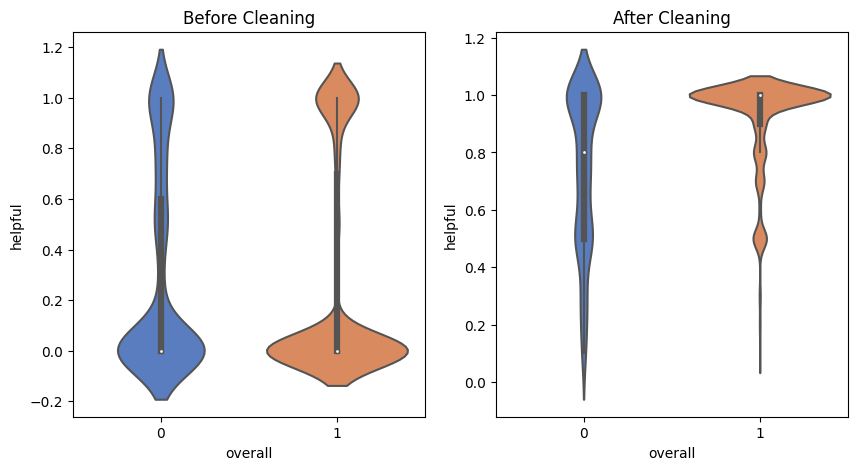

In [12]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

# Plot violinplot of overall vs helpful before cleaning
overall_help_before = pd.DataFrame(df, columns=['overall', 'helpful'])
sns.violinplot(x=overall_help_before['overall'], y=overall_help_before['helpful'], ax=axs[0])
axs[0].set_title('Before Cleaning')

# Remove the rows with 0 helpful rating
df_cleaned = df[df['helpful']  != 0.00]

# Plot violinplot of overall vs helpful after cleaning
overall_help_after = pd.DataFrame(df_cleaned, columns=['overall', 'helpful'])
sns.violinplot(x=overall_help_after['overall'], y=overall_help_after['helpful'], ax=axs[1])
axs[1].set_title('After Cleaning')

# Display the subplots
plt.show()

### Overall vs Date

As seen before there are much reviews on 2013-2014 then the other years.  

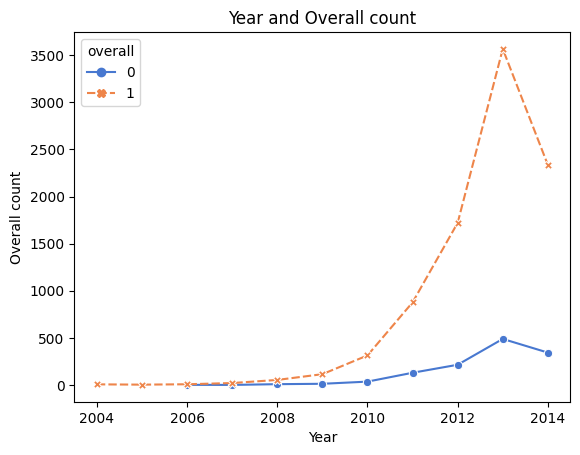

In [13]:
overall_date = pd.DataFrame(df, columns=['overall', 'reviewTime']) 
overall_date['year'] = df.reviewTime.dt.year
overall_count = overall_date.groupby(['year','overall'])['overall'].count().unstack()
sns.lineplot(data=overall_count, markers=True)
plt.title('Year and Overall count')
plt.xlabel('Year')
plt.ylabel('Overall count')
plt.show()


## Feature Engineering

The goal of the feature Engineering to extract more meaningful information from the text data that can help the model make accurate predictions. For that, on this section Im going to use some techiques on the `reviews` column from the dataset.

### Text Preprocessing

`stop` is a set of stopwords, which are common words in a language that are often removed from text data before analysis as they do not carry much meaning.

In [14]:
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)
stop_words.update(punctuation)

Create a function to clean the text from the `reviews` column

In [15]:
def review_cleaning(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    words = text.split()
    words = [w for w in words if w not in stop_words]
    text = ' '.join(words)
    return text

df['clean_reviews'] = df['reviews'].apply(review_cleaning)

To visualize the impact of cleaning the review column, I randomly selected rows from the dataframe and compared the original reviews with the cleaned reviews. This enables us to observe the changes that occur after processing the text and identify any emerging patterns.

In [16]:
df[['reviews','clean_reviews']].sample(n=5)

,reviews,clean_reviews
55,This is good cable. Excellent 1/4&#34; plugs. ...,good cable excellent plugs lugs solder joints ...
6531,This pedal does add reverb and it is adjustabl...,pedal add reverb adjustable different effects ...
8269,The tabs broke off right out of the package (t...,tabs broke right package reviews made aware ma...
6173,"this pedal worked well, but I sent it back bec...",pedal worked well sent back thru marshall itge...
7633,"While not as soft and supple as suede straps, ...",soft supple suede straps pretty sure solid lit...


## Text Analysis

### Word Frequency

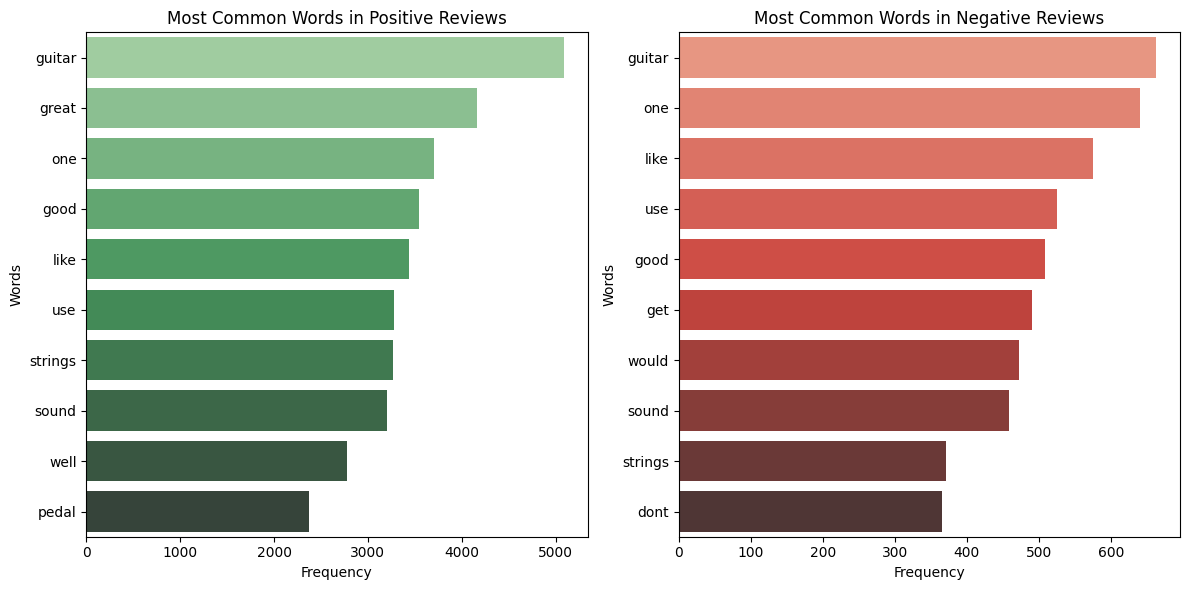

In [17]:
# Create separate dataframes for positive and negative reviews
pos_reviews = df[df['overall'] == 1]
neg_reviews = df[df['overall'] == 0]

# Combine all the words for positive and negative reviews
all_pos_reviews = ' '.join(pos_reviews['clean_reviews'])
all_neg_reviews = ' '.join(neg_reviews['clean_reviews'])

# Tokenize positive and negative reviews
pos_tokens = word_tokenize(all_pos_reviews)
neg_tokens = word_tokenize(all_neg_reviews)

# Frequency distribution for positive and negative reviews
pos_freq_dist = nltk.FreqDist(pos_tokens)
neg_freq_dist = nltk.FreqDist(neg_tokens)

# Most common word for positive and negative reviews
pos_most_common_words = pos_freq_dist.most_common(10)
neg_most_common_words = neg_freq_dist.most_common(10)

# Plot most common words for positive and negative reviews
fig, axs = plt.subplots(ncols=2, figsize=(12,6))

sns.barplot(x=[val[1] for val in pos_most_common_words], y=[val[0] for val in pos_most_common_words], ax=axs[0], palette='Greens_d')
axs[0].set_xlabel('Frequency')
axs[0].set_ylabel('Words')
axs[0].set_title('Most Common Words in Positive Reviews')

sns.barplot(x=[val[1] for val in neg_most_common_words], y=[val[0] for val in neg_most_common_words], ax=axs[1], palette='Reds_d')
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Words')
axs[1].set_title('Most Common Words in Negative Reviews')

plt.tight_layout()
plt.show()

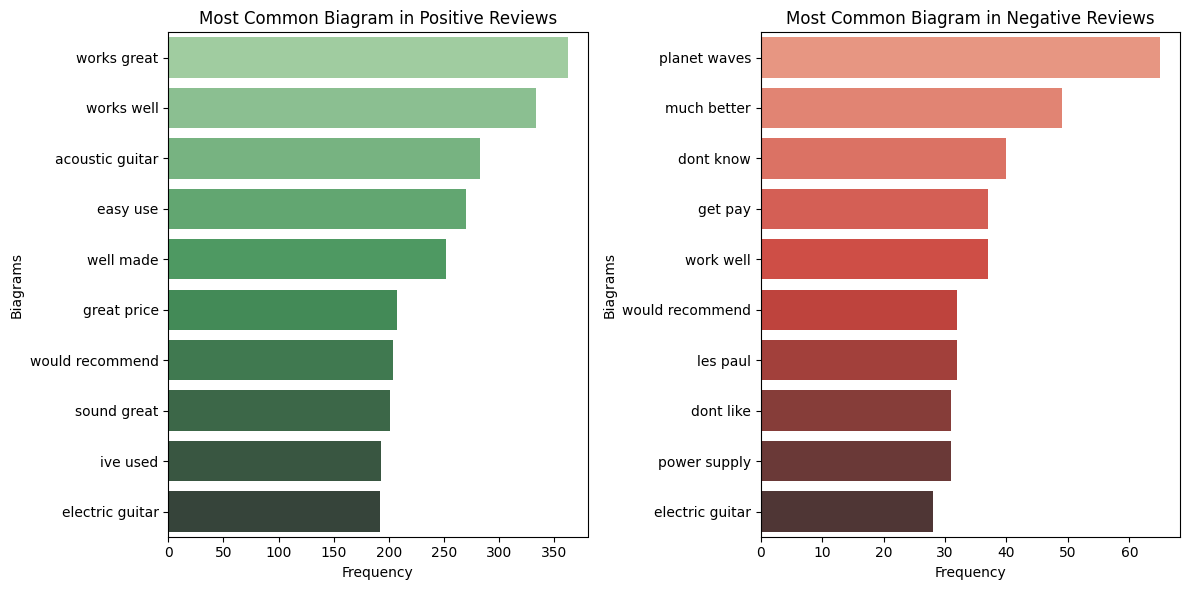

In [18]:

tokens_pos = word_tokenize(all_pos_reviews)
tokens_neg = word_tokenize(all_neg_reviews)

bigrams_pos = list(nltk.bigrams(tokens_pos))
bigrams_neg = list(nltk.bigrams(tokens_neg))

pos_freq_dist_b = nltk.FreqDist(bigrams_pos)
neg_freq_dist_b = nltk.FreqDist(bigrams_neg)

pos_b_most_common_words = pos_freq_dist_b.most_common(10)
neg_b_most_common_words = neg_freq_dist_b.most_common(10)

# Plot most common words for positive and negative reviews
fig, axs = plt.subplots(ncols=2, figsize=(12,6))

sns.barplot(x=[val[1] for val in pos_b_most_common_words], y=[val[0][0] + ' ' + val[0][1] for val in pos_b_most_common_words], ax=axs[0], orient='h', palette='Greens_d')
axs[0].set_xlabel('Frequency')
axs[0].set_ylabel('Biagrams')
axs[0].set_title('Most Common Biagram in Positive Reviews')

sns.barplot(x=[val[1] for val in neg_b_most_common_words], y=[val[0][0] + ' ' + val[0][1] for val in neg_b_most_common_words], ax=axs[1], orient='h', palette='Reds_d')
axs[1].set_xlabel('Frequency')
axs[1].set_ylabel('Biagrams')
axs[1].set_title('Most Common Biagram in Negative Reviews')

plt.tight_layout()
plt.show()

## Modeling 

### Lemmatization

In this section, I will be using lemmatization to transform words in the text to their base or dictionary form. Lemmatization is a technique used to group together the inflected forms of a word so that they can be analyzed as a single item. The goal of lemmatization is to reduce the number of unique words in the text while preserving the meaning of the original text.

In [19]:
def get_wordnet_pos(word):
    """Map POS tag to first character used by WordNetLemmatizer"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_text(text):
    # Tokenize the text into words
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    lemmatized_text = ' '.join(lemmatized_words)
    return lemmatized_text

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

df['lemmatized_reviews'] = df['clean_reviews'].apply(lemmatize_text)

### Handle Imbalance Data 

In this project, I will be using SMOTE (Synthetic Minority Over-sampling Technique) to handle the imbalanced dataset. The number of positive reviews in this dataset is much higher than the number of negative reviews. This can lead the model to perform very well for positive reviews and poorly for negative reviews. SMOTE generates synthetic samples of the minority class by creating new reviews based on the existing ones. To achieve this, I will be using SMOTE from the imblearn library. It's important to perform this technique after splitting the data into training and test sets to avoid any data leakage from the test and training sets.
But first must to convert the the `x_train` into numerical representation using `TfidfVectorizer`

In [20]:
# Vectorize
tfidf_vectorizer = TfidfVectorizer()
X = tfidf_vectorizer.fit_transform(df['lemmatized_reviews'])
y = df['overall']

# SMOTE
smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(X, y)

df_smote = pd.DataFrame({
    'Original': [f'{Counter(x_resampled)}'],
    'Resampled': [f'{Counter(y_resampled)}'],

})
original_dataset = pd.DataFrame.from_dict(Counter(y), orient='index')
resampled_dataset = pd.DataFrame.from_dict(Counter(y_resampled), orient='index')
df_smote = pd.concat([original_dataset, resampled_dataset], axis=1)
df_smote.columns = ['Before SMOTE', 'After SMOTE']
df_smote

TypeError: unhashable type: 'csr_matrix'

### Split data

In this section, I will split the pre-processed data into training and test sets. The training set will be used to train the model, while the test set will be used to evaluate the performance of the trained model. I will use a ratio of 80% for the training set and 20% for the test set.

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x_resampled, y_resampled,test_size = 0.2 , random_state = 0)

### Train the model

On this section, I will train different models using a pipeline. The pipeline will include a TfidfVectorizer to vectorize the data and an instance of a model. For this project, I will be using LogisticRegression, MultinomialNB, SVC, and RandomForestClassifier models.


In [ ]:
models = {
       'LogisticRegression': LogisticRegression(random_state=0),
       'MultinomialNB':MultinomialNB(),
       'SVM':SVC(kernel='linear', random_state=0),
       'RandomForest':RandomForestClassifier(random_state=0),
}
    
results = []
best_accuracy = 0
best_model = None

for model_name, model_pipeline in models.items():
    model_pipeline.fit(x_train, y_train)
    accuracy = model_pipeline.score(x_test, y_test)
    
    results.append({'Model': model_name, 'Accuracy': accuracy})

    # Save the best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model_pipeline

# Save the best model using pickle
with open(f'best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

df_acc = pd.DataFrame(results)
df_acc = df_acc.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
df_acc

### Classification metrics

In this section, the best model will be evaluated using a confusion matrix to identify the true positive, true negative, false positive, and false negative. Finally, a report will be created to analyze some of the metrics such as precision, recall, and f1-score.


In [ ]:
# Load the best model
with open('best_model.pkl', 'rb') as f:
    best_model = pickle.load(f)

# Get predictions for test set using the best model
y_pred = best_model.predict(x_test)
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Conclusion based on the confusion matrix:

* The model correctly classified 1820 instances as negative reviews (class 0) and 1633 instances as positive reviews (class 1) 
* The model incorrectly classified 15 instances as negative reviews that were actually positive reviews and 141 instances as positive reviews that were actually negative reviews

In [ ]:
report = classification_report(y_test, y_pred, target_names=['0', '1'], output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report

Conclusios of based on the metrics: 
* Based on the confusion matrics the model just missed 141 out of 1633 for positve reviews and for the 
* The overall accuracy of the model is 0.95, indicating that is performing well in classifying the reviews as positive and negative
* The precision for both cases are very good 
* The recall for the positive reviews is 0.99, indicating that the model is very good identoifying positive reviews as positive
* The recall for the negative reviews is less precise then the positive
* The F1-score for positive reviews is very high, indicating that the model is very good at identifying positive reviews
* The F1-score for negative reviews is also very high, indicating that the model is very good at identifying negative reviews
* The weighted average F1-score of the model is 0.957, which is quite high and indicates that the model is performing well overall

## Final conclusions:

Based on this project this is my conclusions:
* The dataset was highly imbalanced with a majority of positive reviews compared to negative reviews
* Balancing the dataset using SMOTE improved the model's performance significantly by increasing its ability to identify negative reviews
* The accuracy score of the best model was high at 95.6%
* The precision and recall scores were high for both positive and negative reviews. The model was better at identifying positive reviews, but it still performed well for negative reviews
* The macro-average F1-score was 0.96, indicating good performance on both classes, while the weighted average F1-score was slightly lower at 0.95
* Limited variety of the datset, with most of the reviews being for guitars
* Future work could include expanding the datset with more varaity of reviews or products and use other NLP techiques to improve performce.